In [1]:
import os
import shutil
import tempfile
import nibabel as nib

import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import torch
import torch.nn as nn
from torch.nn import MSELoss
from monai.apps import download_url, download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import BendingEnergyLoss, MultiScaleLoss, DiceLoss, SSIMLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import LocalNet
from monai.transforms import *
from monai.utils import set_determinism, first

from math import log10

import tqdm
from tqdm import tqdm

import torchvision
from torchvision import transforms 
import torch.nn.functional as F

import os
from monai.config import print_config
from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter)
from monai.transforms import *

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.2
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/hufsbme/anaconda3/envs/virtual/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/install

In [2]:
import pandas as pd

df = pd.read_csv('psycho_2d_ddpm.csv')
len(df)

6780

In [3]:
df_t = df[:6000]
# df_v = df[-200:-150]
df_ts = df[-780:]
len(df_t),len(df_ts)

(6000, 780)

In [4]:
df_t.iloc[0,0]

'/nfs/hufsaims/kjh/project/psycho/data_2d/orig/22062302_5.png'

In [5]:
df_t.iloc[0,1]

'/nfs/hufsaims/kjh/project/psycho/data_2d/n4/22062302_5.png'

In [6]:
train_images1 = df_t['orig'].tolist()
train_images2 = df_t['bf'].tolist()
train_images3 = df_t['n4'].tolist()

data_dicts_tr = [
    {'orig': image_name1, "bf": image_name2, "n4": image_name3}
    for image_name1, image_name2, image_name3 in zip(train_images1, train_images2, train_images3)
]

train_files = data_dicts_tr
print('train dataset num: ', len(train_files))

train dataset num:  6000


In [7]:
ts_images1 = df_ts['orig'].tolist()
ts_images2 = df_ts['bf'].tolist()
ts_images3 = df_ts['n4'].tolist()

data_dicts_ts = [
    {'orig': image_name1, "bf": image_name2, "n4": image_name3}
    for image_name1, image_name2, image_name3 in zip(ts_images1, ts_images2, ts_images3)
]

ts_files = data_dicts_ts
print('train dataset num: ', len(ts_files))

train dataset num:  780


In [8]:
IMG_SIZE = 512
transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
train_transforms0 = Compose(
    [
        LoadImaged(keys=['orig', 'bf', 'n4']),
        EnsureChannelFirstd(keys=['orig', 'bf', 'n4']),
        ScaleIntensityd(
                keys=['orig', 'bf', 'n4'],
                minv=0.0,
                maxv=1.0,
            ), 

#         RandShiftIntensityd(
#             keys=["image1"],
#             offsets=0.10,
#             prob=0.5,
#         ),        #    
        
#         RandZoomd(
#             keys=["image1", "seg"],
#             prob = 0.75,
#             min_zoom = 0.9,
#             max_zoom = 1.2,
#             mode = ['area','nearest']
#         ),
            
        Resized(keys=['orig', 'bf', 'n4'], spatial_size=(IMG_SIZE, IMG_SIZE)),        

        ToTensord(keys=['orig', 'bf', 'n4']),
    ]
)

In [9]:
IMG_SIZE = 512
transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
ts_transforms0 = Compose(
    [
        LoadImaged(keys=['orig', 'bf', 'n4']),
        EnsureChannelFirstd(keys=['orig', 'bf', 'n4']),
        ScaleIntensityd(
                keys=['orig', 'bf', 'n4'],
                minv=0.0,
                maxv=1.0,
            ), 

#         RandShiftIntensityd(
#             keys=["image1"],
#             offsets=0.10,
#             prob=0.5,
#         ),        #    
        
#         RandZoomd(
#             keys=["image1", "seg"],
#             prob = 0.75,
#             min_zoom = 0.9,
#             max_zoom = 1.2,
#             mode = ['area','nearest']
#         ),
            
        Resized(keys=['orig', 'bf', 'n4'], spatial_size=(IMG_SIZE, IMG_SIZE)),        

        ToTensord(keys=['orig', 'bf', 'n4']),
    ]
)


In [10]:
# valid_transforms0 = Compose(
#     [
#         LoadImaged(keys=["img","gt"]),
#         EnsureChannelFirstd(keys=["img","gt"]),
#         ScaleIntensityd(
#                 keys=["img", 'gt'],
#                 minv=0.0,
#                 maxv=1.0,
#             ), 

# #         RandShiftIntensityd(
# #             keys=["image1"],
# #             offsets=0.10,
# #             prob=0.5,
# #         ),        #    
        
# #         RandZoomd(
# #             keys=["image1", "seg"],
# #             prob = 0.75,
# #             min_zoom = 0.9,
# #             max_zoom = 1.2,
# #             mode = ['area','nearest']
# #         ),
            
# #         SpatialPadd(keys=["img","gt"], spatial_size=(256, 256, 256)),        


# #         RandSpatialCropd(keys=["img","gt"],
# #                          roi_size=(128, 128, 128), 
# #                          max_roi_size=None, 
# #                          random_center=True, 
# #                          random_size=False
# #                         ),

#         ToTensord(keys=["img","gt"]),
#     ]
# )

In [11]:
ts_ds0 = CacheDataset(
    data=ts_files,
    transform=ts_transforms0,
)
ts_BATCH_SIZE = 1
ts_loader = DataLoader(
    ts_ds0, batch_size=ts_BATCH_SIZE, shuffle=True, 
)
device = 'cpu'

Loading dataset: 100%|██████████████████████████████████████████████████████| 780/780 [00:10<00:00, 77.37it/s]


In [12]:
train_ds0 = CacheDataset(
    data=train_files,
    transform=train_transforms0,
)
BATCH_SIZE = 8
train_loader = DataLoader(
    train_ds0, batch_size=BATCH_SIZE, shuffle=True, 
)
device = 'cpu'

Loading dataset: 100%|████████████████████████████████████████████████████| 6000/6000 [01:19<00:00, 75.93it/s]


In [13]:
# for step, batch_data in enumerate(train_loader):
#     x, y = (
#         batch_data["orig"].to(device),
#         batch_data["n4"].to(device),
#     )
    
#     plt.imshow(x[0, 0])
#     plt.show()
#     plt.imshow(y[0, 0])
#     plt.show()

# Forwad Process

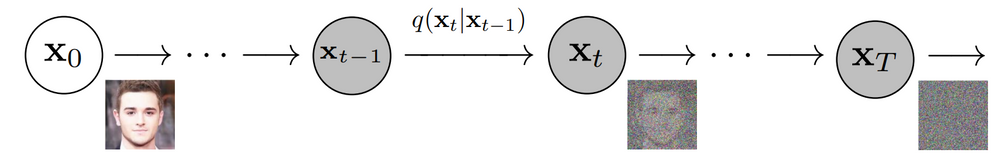

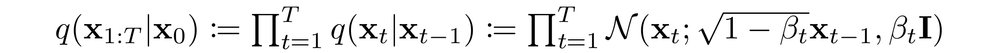

https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

In [15]:
def make_beta_schedule(schedule, timesteps, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas ## float64 for accuracy

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    btc = t.shape[0]
#     btc = t
    out = vals.gather(-1, t.cpu())
    o = out.reshape(btc, *((1,) * (len(x_shape) - 1)))
    return o.to(device)

def hampel(a,size):
    fn = np.random.normal(loc=0, scale=1, size=(size))
    fc = cauchy.rvs(loc=0.7, scale=1, size=(size))
    fh = (1-a)*fn + a*fc
    fh = torch.tensor(fh)
    return fh

def forward_diffusion_sample(noise, x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    if noise == "gaussian":
        noise = np.random.normal(size=x_0.shape)
        noise = torch.tensor(noise).type(torch.float32)
    elif noise == "cauchy":
        noise = np.random.standard_cauchy(x_0.shape)
        noise = torch.tensor(noise).type(torch.float32)
    elif noise == "hampel":
        noise = hampel(1e-06, x_0.shape).type(torch.float32)
    
    x_0 = torch.Tensor(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
#     print("sqrt_alphas_cumprod_t : ",sqrt_alphas_cumprod_t)
#     print("sqrt_one_minus_alphas_cumprod_t : ", sqrt_one_minus_alphas_cumprod_t)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 1000+1
# betas = linear_beta_schedule(timesteps=T)
betas = make_beta_schedule(schedule='linear', timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [16]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_cumprod_prev) / (1 - alphas_cumprod))
posterior_mean_coef_2 = ((1 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1 - alphas_cumprod))
posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = get_index_from_list(posterior_mean_coef_1, t, x_0)
#     coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = get_index_from_list(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = get_index_from_list(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [17]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    else:
        image = image
    plt.imshow(reverse_transforms(image), cmap='gray')
    plt.axis("off")

In [18]:
batch = first(train_loader)
a,b,c = batch['orig'], batch['bf'], batch['n4']

/tmp/ipykernel_3632753/1063163026.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(141)


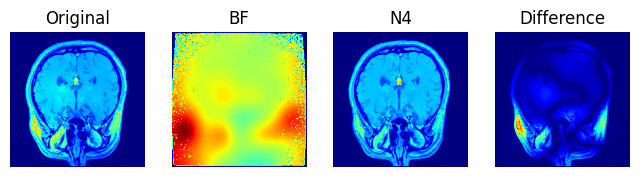

In [19]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.subplot(141)
plt.imshow(a[0][0], cmap='jet')
plt.title("Original")
plt.axis("off")
plt.subplot(142)
plt.imshow(b[0][0], cmap='jet')
plt.title("BF")
plt.axis("off")
plt.subplot(143)
plt.imshow(c[0,0,:,:], cmap='jet')
plt.title("N4")
plt.axis("off")
plt.subplot(144)
plt.imshow(np.abs(a[0,0,:,:] - c[0,0,:,:]), cmap='jet')
plt.title("Difference")
plt.axis("off")

plt.show()

In [20]:
noises = ["gaussian","cauchy","hampel"]

In [21]:
import seaborn as sns

In [22]:
FWD = []

hampel


/tmp/ipykernel_3632753/1495923464.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, int(num_images+1), int((idx/stepsize) + 1))


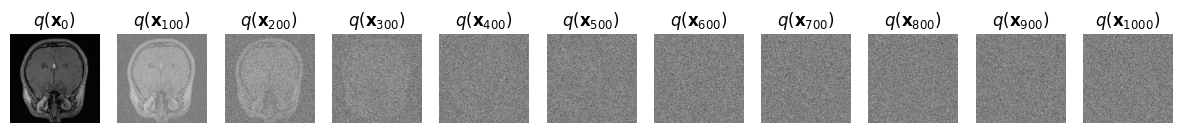

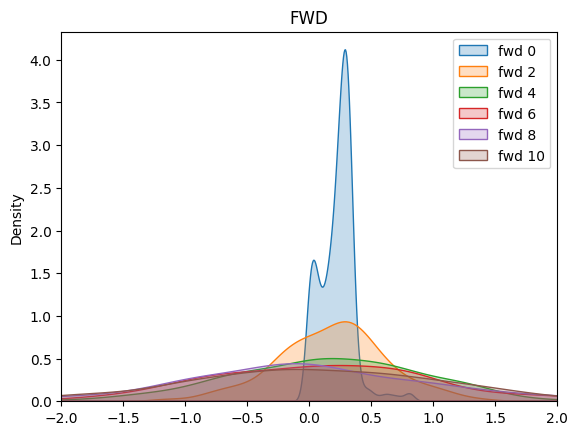

In [23]:
# device = "cpu"
at = 2
print(noises[at])
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)
fwd = []
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, int(num_images+1), int((idx/stepsize) + 1))
    pred, noise = forward_diffusion_sample(noises[at], a, t)
    fwd.append(pred)
    FWD.append(pred)
    show_tensor_image(pred)
    plt.title('$q(\mathbf{x}_{'+str(idx)+'})$')
plt.show()
sns.kdeplot(fwd[0][0,0,:,256], shade=True, label=f"fwd 0")
sns.kdeplot(fwd[2][0,0,:,256], shade=True, label=f"fwd 2")
sns.kdeplot(fwd[4][0,0,:,256], shade=True, label=f"fwd 4")
sns.kdeplot(fwd[6][0,0,:,256], shade=True, label=f"fwd 6")
sns.kdeplot(fwd[8][0,0,:,256], shade=True, label=f"fwd 8")
sns.kdeplot(fwd[-1][0,0,:,256], shade=True, label=f"fwd 10")
plt.title(f"FWD")
plt.xlim(-2,2)
plt.legend()
plt.show()

<AxesSubplot: ylabel='Density'>

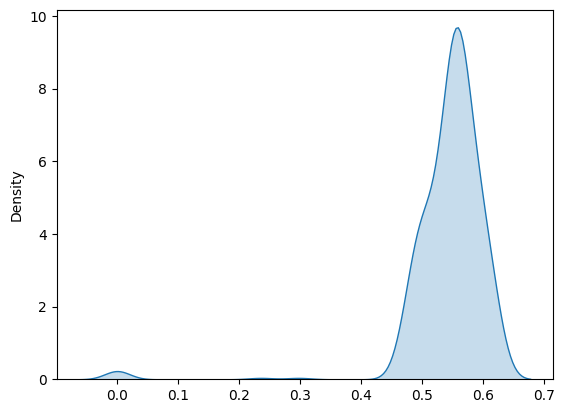

In [24]:
sns.kdeplot(b[0,0,:,256], shade=True, label="Bias Field")

In [25]:
# sns.kdeplot(FWD[10][0,0,:,256], shade=True, label="Gaussain")
# sns.kdeplot(FWD[20][0,0,:,256], shade=True, label="Cauchy")
# sns.kdeplot(FWD[-1][0,0,:,256], shade=True, label="Hampel")
# plt.title(f"Compare Different Noise / FWD")
# plt.xlim(-2,2)
# # plt.ylim(0,3.5)
# plt.legend()
# plt.show()

# Model

In [26]:
from torch import nn
import math


class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.silu  = nn.SiLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.silu(self.conv1(x)))
        # Time embedding
        time_emb = self.silu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.silu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1 ## 수정필요
        down_channels = (64, 128, 256, 1024, 1024)
        up_channels = (1024, 1024, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 64

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))


# Loss

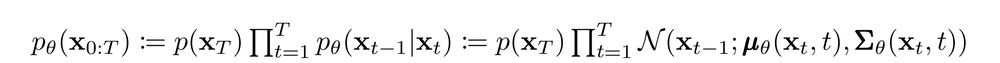

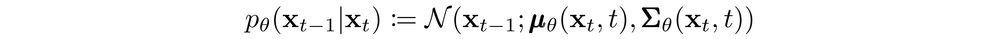

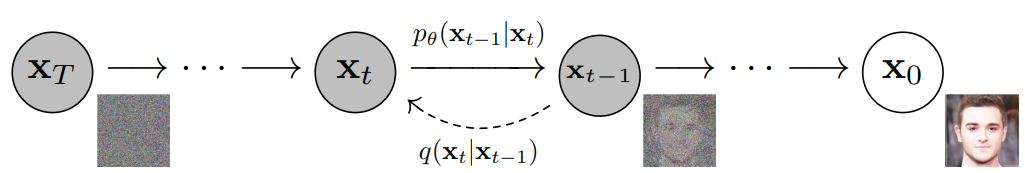

In [27]:
# @torch.no_grad()
# def sample_timestep(x, t):
#     """
#     Calls the model to predict the noise(bf) in the image and returns 
#     the denoised image(n4). 
#     Applies noise(bf) to this image(corrupted), if we are not in the last step yet.
#     """
#     betas_t = get_index_from_list(betas, t, x.shape)
#     sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
#         sqrt_one_minus_alphas_cumprod, t, x.shape
#     )
#     sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
#     # Call model (current image - noise prediction)
#     model_mean = sqrt_recip_alphas_t * (
#         x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
#     )
# #     print(model_mean.shape)
#     posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
#     if 0 in t.tolist():
# #         print("t : 0", model_mean.shape)
#         return model_mean
#     else:
# #         noise = torch.randn_like(x)
#         cauchy = np.random.standard_cauchy(x.shape) ## Cauchy distribution
#         cau = torch.Tensor(cauchy).to(device)
#         return model_mean + torch.sqrt(posterior_variance_t) * cau

# @torch.no_grad()
# def sample_plot_image(IMG_SIZE, img):
#     # Sample noise
#     img_size = IMG_SIZE
# #     img = torch.randn((1, 1, img_size, img_size), device=device)
#     img = img
#     plt.figure(figsize=(15,15))
#     plt.axis('off')
#     num_images = int(5)
#     stepsize = int(T/num_images)

#     for i in range(0,T)[::-1]:
#         t = torch.full((1,), i, device=device, dtype=torch.long)
#         imgg = sample_timestep(img, t)
# #         print(imgg.shape)
#         imgg = imgg[0,:,:,:]
#         if i % stepsize == 0:
#             plt.subplot(1, int(num_images), int(i/stepsize+1))
#             show_tensor_image(imgg.detach().cpu())
#             plt.title('$q(\mathbf{x}_{'+str(i)+'})$')
#     plt.show()          

In [28]:
def image_process(origin, fwd, rvs, target):
    origin = origin[0,0,:,:]
    fwd = fwd[0,0,:,:]
    rvs = rvs[0,0,:,:]
    target = target[0,0,:,:]
    
    plt.figure(figsize=(8,8))
    plt.subplot(141)
    plt.imshow(origin.detach().cpu(), cmap='gray')
    plt.axis("off")
    plt.title("Original Image", fontsize=10)
    
    plt.subplot(142)
    plt.imshow(fwd.detach().cpu(), cmap='gray')
    plt.axis("off")
    plt.title("Forward Process", fontsize=10)
    
    plt.subplot(143)
    plt.imshow(rvs.detach().cpu(), cmap='gray')
    plt.title("Reverse Process", fontsize=10)
    plt.axis("off")
    
    plt.subplot(144)
    plt.imshow(np.abs(target.detach().cpu() - rvs.detach().cpu()), cmap='jet')
    plt.title("Diff. N4 - Reverse", fontsize=10)
    plt.axis("off")
    
    plt.show()

# Train _ Hampel Noise

In [29]:
from IQA_pytorch import SSIM, utils
ssim = SSIM(channels=1)

In [30]:
dice = DiceLoss(jaccard=False, reduction='mean', smooth_nr=1e-9, smooth_dr=1e-09)
mse = torch.nn.MSELoss(reduction='mean')

Epoch 0 | L2_loss: 0.11 Dice_loss: 1.15 |
        | PSNR: 9.66 AVG_SSIM: -0.01


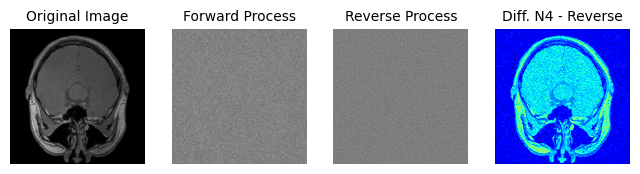

Epoch 32 | L2_loss: 0.07 Dice_loss: 0.82 |
        | PSNR: 11.66 AVG_SSIM: 0.02


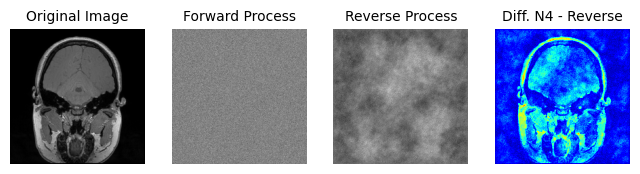

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-08)
epochs = 512
l2,dices,sim = [],[],[]

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        corrupted = batch['orig'].to(device)
#         bf = batch['bf'].to(device)
        n4 = batch['n4'].to(device)
        
        t_step = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        n4_diff, noise = forward_diffusion_sample(noises[-1], corrupted, t_step, device)
        n4_pred = model(n4_diff, t_step)
        l2_loss = mse(n4_pred, n4)
        dice_loss = dice(n4_pred, n4)
        l2.append(l2_loss.item())
        dices.append(dice_loss.item())
        psnr = 10*torch.log10(torch.tensor(1/l2_loss.item()))
        ssim_loss = ssim(n4_pred, n4, as_loss=False)
        ssim_loss = torch.mean(ssim_loss)
        sim.append(ssim_loss)
        
        l2_loss.backward()
        
        optimizer.step()

        if epoch % 32 == 0 and step == 0:
            print(f"Epoch {epoch} | L2_loss: {l2_loss.item():.2f} Dice_loss: {dice_loss.item():.2f} |\n        | PSNR: {psnr.item():.2f} AVG_SSIM: {ssim_loss.item():.2f}")
            image_process(corrupted, n4_diff, n4_pred, n4)
            


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(l2, label="l2")
plt.plot(dices, label="DICE")
plt.xlim(0,513)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()

# Test_Hampel Noise

In [ ]:
first(ts_loader)['orig'].shape

In [ ]:
t_step = torch.tensor([0]).long().cuda()
t_step

In [ ]:
def test_img_process(origin, n4, target):
    origin = origin[0,0,:,:]
    n4 = n4[0,0,:,:]
    target = target[0,0,:,:]
    
    plt.figure(figsize=(8,8))
    plt.subplot(141)
    plt.imshow(origin.detach().cpu(), cmap='gray')
    plt.axis("off")
    plt.title("Original Image", fontsize=10)
    
    plt.subplot(142)
    plt.imshow(n4.detach().cpu(), cmap='gray')
    plt.axis("off")
    plt.title("N4", fontsize=10)
    
    plt.subplot(143)
    plt.imshow(target.detach().cpu(), cmap='gray')
    plt.title("Model", fontsize=10)
    plt.axis("off")
    
    plt.subplot(144)
    plt.imshow(np.abs(n4.detach().cpu() - target.detach().cpu()), cmap='gray')
    plt.title("N4 - Model", fontsize=10)
    plt.axis("off")
    
    plt.show()

In [ ]:
for step, batch in enumerate(ts_loader):
    
    model.eval()

    corrupted = batch['orig'].to(device)
    bf = batch['bf'].to(device)
    n4 = batch['n4'].to(device)
    
#     corrupted_img.append(corrupted.detach().cpu())
#     bf_img.append(bf.detach().cpu())
#     n4_img.append(n4.detach().cpu())

#     t_step = torch.randint(0, T, (ts_BATCH_SIZE,), device=device).long()
    t_step = torch.tensor([0]).long().cuda()
    n4_diff, noise = forward_diffusion_sample(corrupted, t_step, device)
    n4_pred = model(n4_diff, t_step)
    
    l2_loss = mse(n4_pred, n4)
    dice_loss = dice(n4_pred, n4)
    data_range = torch.max(n4) - torch.min(n4)
    psnr_loss = 10 * torch.log10((data_range ** 2) / l2_loss)
    ssim_loss = ssim(n4_pred, n4, as_loss=False)
    
    
    if step % 100 == 0:
        print(f"step {step} | MSE: {l2_loss.item():.4f} DICE: {dice_loss.item():.4f} PSNR : {psnr_loss.item():.4f} SSIM : {ssim_loss.item():.4f}")
        test_img_process(corrupted, n4, n4_pred)